# Preprocessing files 


In [1]:
#!python3 -m pip install python_speech_features # Install PSF specifically on python3.
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
from python_speech_features import mfcc, fbank
import matplotlib.pyplot as plt
import tracemalloc
from SerialTriggerDecoder import SerialTriggerDecoder
from scipy import signal
# Import fft
from scipy.fftpack import fft


tracemalloc.start() # Enable memory profiling

#

## Find files, and list structure

In [2]:

# OS walk through the directory to find the files
#root_dir = '//uni.au.dk/dfs/Tech_EarEEG/Students/Msc2022_BCM_AkselStark'
root_dir = 'bcm_activity_dataset'
data = [] # Empty list to store all hdf5 files in the directory

for subdir, dirs, files in sorted(os.walk(root_dir)):
    for file in files:
        if "hdf5" in file:
            print("\n\n\n")
            # Load the hdf5 file, and append to the list
            print(file)
            
            data.append(h5py.File(os.path.join(subdir, file), 'r'))
            
            print(f'{subdir}/{file}') # Print the filename
            keylist = list(data[0].keys())
            print( keylist) # Print the keys of the hdf5 file
            
            
#data = data[:3] # Create subset of the files, to create training and validation set
del data[2]




for i,j in enumerate(data):
    print("\n\n\n")
    print(f'Index of the hdf5 file: {i}') # Print the index of the hdf5 file
    for key in keylist:
        print(key)
        try: # Try to print the keys. If it fails, print the data
            print(f"    {list(data[i][key].keys())}")
        except:
            print("    No subkeys")
            print(f"    {np.array(data[i][key])}")
            s = data[i][key]
                        
                        







2022-09-20_14-58-39.hdf5
bcm_activity_dataset/2022-09-20_14-58-39.hdf5
['DAQ970A', 'streaminfo']




2022-09-20_15-57-37.hdf5
bcm_activity_dataset/2022-09-20_15-57-37.hdf5
['DAQ970A', 'streaminfo']




2022-09-20_15-18-27.hdf5
bcm_activity_dataset/2022-09-20_15-18-27.hdf5
['DAQ970A', 'streaminfo']




2022-09-20_15-38-11.hdf5
bcm_activity_dataset/2022-09-20_15-38-11.hdf5
['DAQ970A', 'streaminfo']




Index of the hdf5 file: 0
DAQ970A
    ['data', 'labels']
streaminfo
    No subkeys
    [(4, b'cf_float32', 1695.5818, b'5125-240-002', b'DAQ970A', 50000, b'DAQ970A_TCPIP_192_168_56_100', b'Generic')]




Index of the hdf5 file: 1
DAQ970A
    ['data', 'labels']
streaminfo
    No subkeys
    [(4, b'cf_float32', 5233.929, b'5125-240-002', b'DAQ970A', 50000, b'DAQ970A_TCPIP_192_168_56_100', b'Generic')]




Index of the hdf5 file: 2
DAQ970A
    ['data', 'labels']
streaminfo
    No subkeys
    [(4, b'cf_float32', 4067.6292, b'5125-240-002', b'DAQ970A', 50000, b'DAQ970A_TCPIP_192_168_56_100'

## Load data, and labels/triggers

In [3]:
# Load data

print(f'Memory usage: {tracemalloc.get_traced_memory()[0]/1000000} MB\n')
data_bcm = []
labels_bcm = []
for file in data:
    print(f"data    {file}")
    data_full = np.array(file['DAQ970A']['data'])
    data_bcm.append(data_full[:,0])
    data_bcm.append(data_full[:,1])
    print(f'Memory usage: {tracemalloc.get_traced_memory()[0]/1000000} MB\n')

    print(f"Labels    {file}")
    labels_bcm.append(file['DAQ970A']['data'][:,3])
    print(f'Memory usage: {tracemalloc.get_traced_memory()[0]/1000000} MB\n')

pass

Memory usage: 0.185319 MB

data    <HDF5 file "2022-09-20_14-58-39.hdf5" (mode r)>
Memory usage: 784.183825 MB

Labels    <HDF5 file "2022-09-20_14-58-39.hdf5" (mode r)>
Memory usage: 980.184561 MB

data    <HDF5 file "2022-09-20_15-57-37.hdf5" (mode r)>
Memory usage: 1764.185121 MB

Labels    <HDF5 file "2022-09-20_15-57-37.hdf5" (mode r)>
Memory usage: 1960.185393 MB

data    <HDF5 file "2022-09-20_15-38-11.hdf5" (mode r)>
Memory usage: 2744.186017 MB

Labels    <HDF5 file "2022-09-20_15-38-11.hdf5" (mode r)>
Memory usage: 2940.186121 MB



## Plot cepstrum


In [4]:
# Plot spectrogram
#plt.pcolormesh(t[0:20], f, np.log(spectrogram_list[segment_index]),shading='auto')
#plt.pcolormesh(np.log(data_mfcc[4][20605:20610,1:].transpose()),shading='auto')
def plot_mfcc(data_mfcc):
    fig = plt.figure(figsize=(30, 5))
    plt.pcolormesh((data_mfcc),shading='auto')
    plt.ylabel('Mel Cepstrum Coefficients')
    plt.xlabel('Time [sec]')
    plt.show()

# Create the labels

## Plot and test the manchester encoding

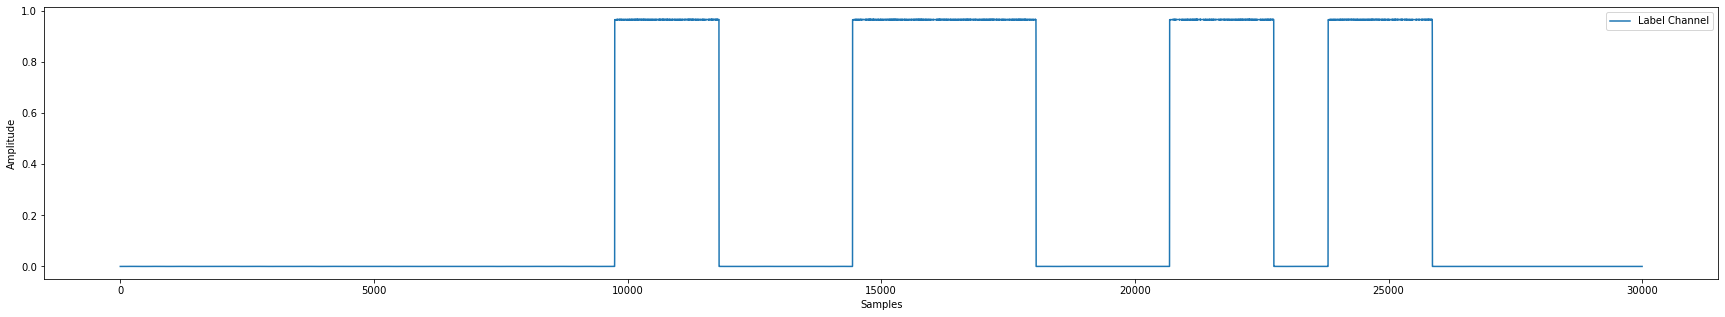

In [5]:
# Doesn't work right now

# Plot the label channel
pos = 0

fig = plt.figure(figsize=(30, 5))

jump = 2 # Measured: clock of manchester encoding
seg_len = 60000
segment = labels_bcm[0][pos:pos+seg_len][0::jump]

plt.plot(segment, label='Label Channel')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()

plt.grid(which = 'minor')

#decode signal from manchester encoding
def manchester_decode(data):
    manchester_decoded = []
    for i in range(0,data.shape[0]-1,2):
        if data[i] == 0 and data[i+1] == 1:
            manchester_decoded.append(0)
        elif data[i] == 1 and data[i+1] == 0:
            manchester_decoded.append(1)
        else:
            manchester_decoded.append(8888) #error
    return manchester_decoded
    

#print(np.rint(segment))
#print(manchester_decode(np.rint(segment)))
plt.show()

## Find the sections, and label them

In [6]:
# Creates a list of the positions of the triggers (and plot them for verification)

last_decoded = -500000
label_index_list = [] # List of the indices of the labels
for i, j in enumerate(np.rint(labels_bcm[0])):
    
    if int(j) and (i > last_decoded+50000*8):
        #print(manchester_decode(np.rint(labels_bcm[0][i-900:i+100000][0::2480])))
        print(f"i: {i}")
        print(f"Time: {i/50000} s")
        last_decoded = i
        
        label_index_list.append(i)
        ''' # Plot
        fig = plt.figure(figsize=(30, 5))
        plt.plot(labels_bcm[1][i-900:i+50000], label='Label Channel')
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        plt.legend()

        plt.grid(which = 'minor')
        plt.show()
        '''
    


i: 19492
Time: 0.38984 s
i: 519489
Time: 10.38978 s
i: 1019486
Time: 20.38972 s
i: 1519483
Time: 30.38966 s
i: 2019481
Time: 40.38962 s
i: 2519478
Time: 50.38956 s
i: 3019475
Time: 60.3895 s
i: 3519472
Time: 70.38944 s
i: 4019470
Time: 80.3894 s
i: 4519467
Time: 90.38934 s
i: 5020452
Time: 100.40904 s
i: 5520449
Time: 110.40898 s
i: 6020446
Time: 120.40892 s
i: 6520443
Time: 130.40886 s
i: 7020440
Time: 140.4088 s
i: 7520438
Time: 150.40876 s
i: 8020435
Time: 160.4087 s
i: 8520432
Time: 170.40864 s
i: 9020429
Time: 180.40858 s
i: 9520427
Time: 190.40854 s
i: 10022045
Time: 200.4409 s
i: 10522042
Time: 210.44084 s
i: 11022039
Time: 220.44078 s
i: 11522036
Time: 230.44072 s
i: 12022033
Time: 240.44066 s
i: 12522031
Time: 250.44062 s
i: 13022028
Time: 260.44056 s
i: 13522025
Time: 270.4405 s
i: 14022022
Time: 280.44044 s
i: 14522019
Time: 290.44038 s
i: 15023764
Time: 300.47528 s
i: 15523762
Time: 310.47524 s
i: 16009096
Time: 320.18192 s
i: 16523756
Time: 330.47512 s
i: 17023753
Time: 34

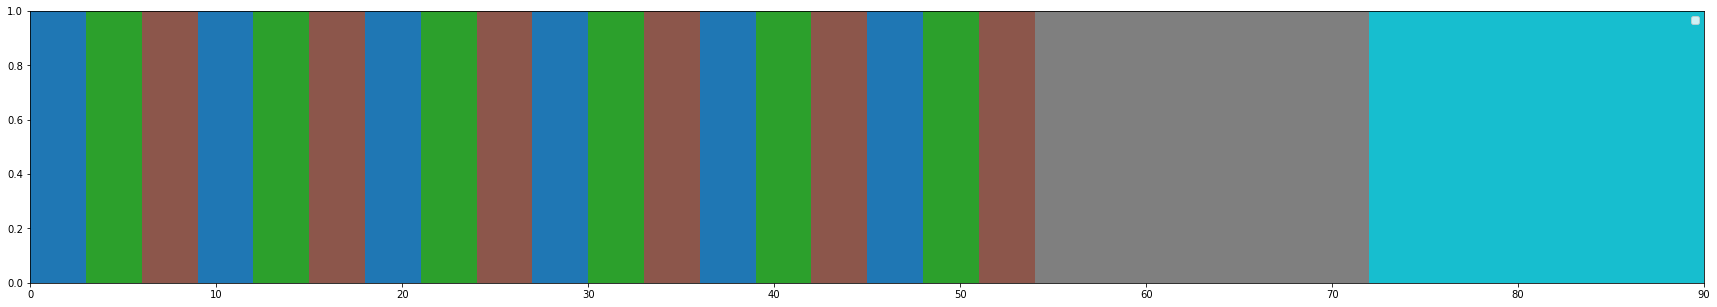

In [7]:
# Make a list of the labels for the triggers

index_labels = [] # A list of labels for the indexes in label_index_list

for i in range(6):
    index_labels.extend([0,0,0,1,1,1,2,2,2,-1])

for i in range(18): index_labels.append(3)
index_labels.append(-1)

for i in range(18): index_labels.append(4)
index_labels.append(-1)

# New list with negative values removed list conprehension
index_labels_new = [x for x in index_labels if x != -1]





# Pcolormesh of index_labels where the labels are > 0
fig = plt.figure(figsize=(30, 5))
plt.pcolormesh(np.array(index_labels_new).reshape(1,-1),shading='auto',cmap='tab10')

# Add legend outside of the plot
plt.legend(['0', '1', '2', '3', '4'], loc='upper right')
plt.show()



## Concatenate the data from each class, calculate the mfcc's and save to 5 files (one for each class)

In [8]:
# Add the sections to 5 lists corresponding to the 5 different labels/classes
''' 
Classes:
    Breathing: 0
    Snoring: 1
    Hold_breath: 2
    Chewing: 3
    Talking: 4
'''
fs = 50000
nested_class_list = [[],[],[],[],[]]


for datastream in data_bcm: # Loop through the data 
    for i, j in enumerate(label_index_list):
        if index_labels[i]>=0:
            nested_class_list[index_labels[i]].append(datastream[j:j+fs*10]) # Append 
            


(33750, 16)
(33750, 16)
[[ -6.44820573  -6.20208488  -5.9503599   -5.70528478  -5.50863665
   -5.31433837  -5.10295802  -4.88937478  -4.66632072  -4.45868865
   -4.25574306  -4.03658949  -3.823309    -3.61483689  -3.40264415
   -3.19174653]
 [-13.37237428 -15.95577723 -16.87256108 -17.52538158 -18.03024944
  -18.52805351 -18.80409872 -19.00311218 -19.21075114 -19.17203469
  -18.82404847 -18.5489352  -18.63295538 -18.6960852  -18.75796978
  -19.16988811]
 [-12.02137615 -14.23426508 -15.15601615 -15.76421833 -16.25697917
  -16.71200349 -17.05550767 -17.36559951 -17.66047274 -17.75014354
  -17.9562107  -17.91332273 -18.01510138 -18.01416147 -18.14497611
  -18.38334715]
 [-10.27957742 -12.46858827 -13.35154312 -13.97103124 -14.49777153
  -14.93549009 -15.29493157 -15.5894221  -15.86261932 -16.1295277
  -16.40078202 -16.6059966  -16.78313382 -16.87545953 -16.9552095
  -17.0149385 ]
 [-11.94710963 -14.19264789 -15.00557885 -15.64809801 -16.17602078
  -16.60443399 -16.9686697  -17.27813608 -1

"\n    #_______________________________________________________Plot spectrogram of each class\n    # FFT of stacked array\n    F = fft(stacked_array[50000:100000])\n    F = F[0:int(len(F)/2)]\n    # Plot the fft\n    \n    ax.plot(10*np.log10(np.square(abs(F))),label = class_label_list[i])\n    # Labels\n    # Add label to plot\n    \n    if i == 0: # Comment out this section when plotting all classes on the same plot\n        ax.set_title('Breathing')\n    elif i == 1:\n        ax.set_title('Snoring')\n    elif i == 2:\n        ax.set_title('Hold breath')\n    elif i == 3:\n        ax.set_title('Chewing')\n    elif i == 4:\n        ax.set_title('Talking')\n        \n    ax.set_xscale('log')\n    ax.set_xlim([10, 10000])\n    plt.xlabel('Frequency (Hz)')\n    plt.ylabel('Power (dB)')\n    plt.grid(which = 'minor')\nplt.legend()\nplt.show()"

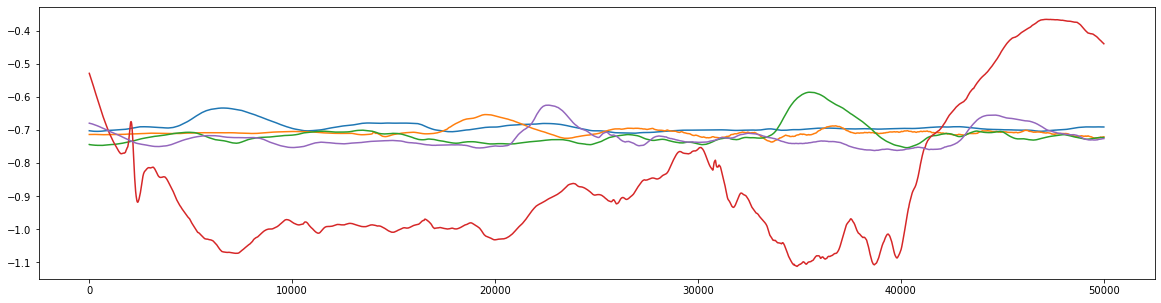

In [9]:

fig, ax = plt.subplots(figsize=(20, 5))
class_label_list = ['Breathing', 'Snoring', 'Hold_breath', 'Chewing', 'Talking']

# Concatenate the arrays, calc mfccs and save them to files
for i, j in enumerate(nested_class_list):
    stacked_array = np.hstack(j)
    
    # Plot the stacked array
    '''fig = plt.figure(figsize=(30, 5))
    plt.plot(stacked_array, label=f'Data for label {i}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(which = 'minor')
    plt.show()'''
    
    # Create and save mfccs
    data_mfcc = mfcc(stacked_array, samplerate = fs, nfft = 1600, winlen=0.032, winstep=0.032, numcep=16) # Sample rate is important when using mel scale
    
    #plot_mfcc(data_mfcc)
    
    np.save(f'data/bcm_alt_3/train/{i}.npy', data_mfcc)
    
    # Create and save spectrogram data
    #f,t, Pxx = signal.spectrogram(stacked_array, fs = fs ,nperseg=int(0.032*fs), noverlap = 0)
    
    
    # Use python speech features to filter the signal using mel scale
    #print(np.std(stacked_array))
    #stacked_array = stacked_array-np.mean(stacked_array)
    #stacked_array = stacked_array/np.std(stacked_array)
    data_spec, _ = fbank(stacked_array, samplerate = fs, nfft = 1600, winlen=0.032, winstep=0.032, nfilt=16)
    print(data_mfcc.shape)
    print(data_spec.shape)
    data_spec = np.log(data_spec)
    print(data_spec[0:5])
    
    # Plot the stacked array
    plt.plot(stacked_array[0:50000])
    
    
    #plot_mfcc(np.transpose(data_spec[0:300])) # Not mfcc, but spectrogram data (mel filtered)
    
    #np.save(f'data/bcm_spectrograms/train/{i}.npy', data_spec)
    
'''
    #_______________________________________________________Plot spectrogram of each class
    # FFT of stacked array
    F = fft(stacked_array[50000:100000])
    F = F[0:int(len(F)/2)]
    # Plot the fft
    
    ax.plot(10*np.log10(np.square(abs(F))),label = class_label_list[i])
    # Labels
    # Add label to plot
    
    if i == 0: # Comment out this section when plotting all classes on the same plot
        ax.set_title('Breathing')
    elif i == 1:
        ax.set_title('Snoring')
    elif i == 2:
        ax.set_title('Hold breath')
    elif i == 3:
        ax.set_title('Chewing')
    elif i == 4:
        ax.set_title('Talking')
        
    ax.set_xscale('log')
    ax.set_xlim([10, 10000])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (dB)')
    plt.grid(which = 'minor')
plt.legend()
plt.show()'''
    
    
    
    

In [10]:
print(np.log(data_spec[100:105]))

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]


/tmp/ipykernel_765578/188160759.py:1: RuntimeWarning: invalid value encountered in log
  print(np.log(data_spec[100:105]))


In [11]:


# Plot the full measurements
'''for i in data_bcm:
    fig = plt.figure(figsize=(30, 5))
    plt.plot(i, label='Label Channel')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(which = 'minor')
    plt.show()
'''

'''for i in data_bcm: 
    mfccs = mfcc(i, samplerate = fs, nfft = 1600, winlen=0.032, winstep=0.032, numcep=16)
    plot_mfcc(mfccs)
    #print(mfccs[0:5])'''

'''
for i in labels_bcm:
    fig = plt.figure(figsize=(30, 5))
    plt.plot(i, label='Label Channel')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(which = 'minor')
    plt.show()'''
    
    
for i in data_bcm: 
    mfccs,_ = fbank(i, samplerate = fs, nfft = 1600, winlen=0.032, winstep=0.032, nfilt=16)
    #plot_mfcc(mfccs.transpose())
    print(np.log(mfccs[100:105]))


[[-10.23023787 -12.39835875 -13.26335312 -13.90861677 -14.48563062
  -14.8947254  -15.26002319 -15.56440125 -15.83424172 -16.11175666
  -16.29046088 -16.46107203 -16.67996933 -16.8848994  -16.85975399
  -16.87123937]
 [-12.91745786 -15.202381   -16.0955389  -16.56305938 -17.05248779
  -17.57262204 -18.0222728  -18.27423736 -18.5769339  -18.62049789
  -18.41839914 -18.27116312 -18.41077364 -18.53370882 -18.72531009
  -18.83973699]
 [-11.25678305 -13.34145481 -14.23659005 -14.95566046 -15.46228502
  -15.89112283 -16.21466701 -16.56078858 -16.80555125 -17.08846878
  -17.26155355 -17.23926542 -17.38137983 -17.54518348 -17.71155594
  -17.80732255]
 [-12.86834441 -15.13631139 -15.97356919 -16.62644226 -17.09377851
  -17.55197979 -17.86970481 -18.21355009 -18.469064   -18.70052903
  -18.61861479 -18.6148592  -18.36936694 -18.50360152 -18.45628512
  -18.75929704]
 [-13.49238838 -15.90104441 -16.94662687 -17.32579738 -17.95514272
  -18.3825807  -18.78430803 -18.89979939 -19.35045248 -19.2857736

In [12]:
# Import the dataset class, and make sure the data is unchanged after loading
from BCM_dataset_v2 import bcmDataset
from BCM_dataset_v2 import concat_train_test_datasets

train_set, val_set = concat_train_test_datasets('data/bcm/', window_size = 3, stride = 3, MFCC_stride = 0.032)


Dataset version: 2.1
Validation set
data/bcm//validation/0.npy
data/bcm//validation/1.npy
data/bcm//validation/2.npy
data/bcm//validation/3.npy
data/bcm//validation/4.npy
Training set
data/bcm//train/0.npy
data/bcm//train/1.npy
data/bcm//train/2.npy
data/bcm//train/3.npy
data/bcm//train/4.npy


torch.Size([93, 16])
tensor([1., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0.])
(372, 16)


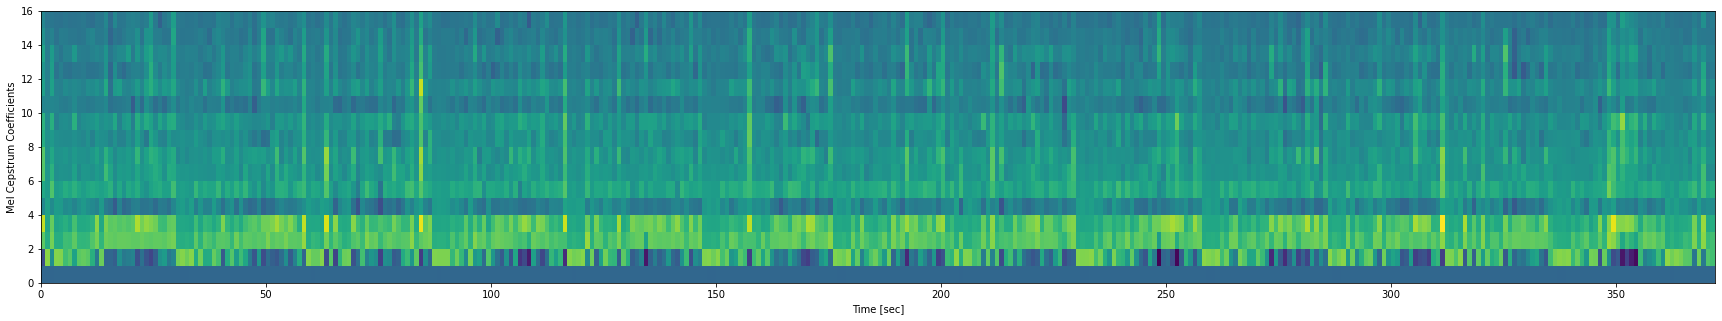

In [13]:

print(train_set[0][0].shape)

mfcc_from_dataset_list = []

for i,j in enumerate(val_set):
    if i > 4:
        mfcc_from_dataset_list.append(j[0])
        print(j[1])
    if len(mfcc_from_dataset_list) > 3: break
    
dataset_mfccs = np.vstack(mfcc_from_dataset_list)

print(dataset_mfccs.shape)
    

plot_mfcc(dataset_mfccs.transpose())